### Form of the likelihood

As seen in the `generating_noise` notebook, both the real and imaginary part of the frequency domain noise, $\tilde{n}(f) = \tilde{n}_r(f) + i\tilde{n}_i(f)$, follow a normal distribution with variance 

$$ \langle \tilde{n}_r^2(f) \rangle = \langle \tilde{n}_i^2(f) \rangle = \frac{1}{4} S_n(f)T $$

where $S_n(f)$ is the power spectral density of the noise, and $T$ is the length of the noise being considered. So, the probability of the real part of the noise having value $\tilde{n}_r$ (in the frequency bin $f_i$) is

$$ p(\tilde{n}_r(f_i)) = \frac{1}{\sqrt{2\pi \frac{1}{4} S_n(f_i)T}} ~ \mathrm{exp} \left[ -\frac{1}{2} \frac{\tilde{n}_r^2(f_i)}{\frac{1}{4}S_n(f_i)T} \right], $$

and similarly for the imaginary part. The complex valued $\tilde{n}(f)$ then follows a distribution

$$ p(\tilde{n}(f_i)) = p(\tilde{n}_r(f_i))p(\tilde{n}_i(f_i)) = \frac{1}{2\pi \frac{1}{4} S_n(f_i)T} ~ \mathrm{exp} \left[ -\frac{1}{2} \frac{\tilde{n}_r^2(f_i) + \tilde{n}_i^2(f_i)}{\frac{1}{4}S_n(f_i)T} \right] = \frac{1}{\frac{1}{2}\pi S_n(f_i)T} ~ \mathrm{exp} \left[ - \frac{2 |\tilde{n}(f_i)|^2 }{S_n(f_i)T} \right]. $$

Bringing the normalization inside the exponential, this can be written (with $\tilde{n}(f_i) = \tilde{n}_i$)

$$ p(\tilde{n}_i) = \mathrm{exp} \left[ - \frac{2 |\tilde{n}_i|^2 }{S_n(f_i)T} - \ln \left( \frac{1}{2}\pi S_n(f_i)T \right) \right]. $$

This implies a likelihood function of the form (with the belief $d_i = h_i(\theta) + n_i)$

$$ \mathcal{L}(d_i|\theta) = \mathrm{exp} \left[ - \frac{2 |\tilde{d}_i - \tilde{h}_i(\theta)|^2 }{S_n(f_i)T} - \ln \left( \frac{1}{2}\pi S_n(f_i)T \right) \right]. $$

Here, $\vec{d} = \{d_0,\, d_1,\, \dots,\, d_{K-1} \}$ is our data, and $h_i(\theta)$ is our model at time $t_i$ for some choice of parameters $\theta$. The likelihood for all the data is the product of the likelihood for each data point:

$$ \mathcal{L}(\vec{d}|\theta) = \prod_{i=0}^{K-1} \mathcal{L}(d_i|\theta), $$

which with the exponential becomes a sum

$$ \mathcal{L}(\vec{d}|\theta) = \mathrm{exp} \sum_{i=0}^{K-1} \left[ - \frac{2 |\tilde{d}_i - \tilde{h}_i(\theta)|^2 }{S_n(f_i)T} - \ln \left( \frac{1}{2}\pi S_n(f_i)T \right) \right]. $$

This is nearly the same as the expression in https://arxiv.org/abs/1409.7215 apart from a factor of half outside the log. See also https://arxiv.org/abs/1809.02293, who don't have the factor of half outside the log, but have a different argument inside the log.

It is also worth being careful about the normalization of the Fourier tranform. In continuous language we have

$$ \tilde{n}(f) = \int_{-\infty}^{\infty} \mathrm{d}t ~ n(t) ~ e^{-2\pi ift}. $$

When we discretize this becomes

$$ \tilde{n}_k = \sum_{m=0}^{N-1} \Delta t ~ n_m ~ e^{-2\pi i \frac{mk}{N}}, \qquad k=0,\,\dots,\,N-1 $$

where $\Delta t$ is the time resolution, and $N$ is the number of data points in the time $T$. Comparing with the NumPy FFT function, https://numpy.org/doc/stable/reference/routines.fft.html, if we use `norm = None` (the default), then all that is missing is the $\Delta t$ factor, so we should multiply by this when performing the FFT.

## Verification

Consider a white noise series $\vec{n} = \{n_0,\, n_1,\, \dots,\, x_{K-1} \}$ with standard deviation $\sigma$. This can be easily generated in the following way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import welch

# Create example time and frequency arrays
fs = 4096
dt = 1/fs
times = np.arange(-4096, 4096, dt)
freqs = np.fft.rfftfreq(len(times), d=dt)

# Number of data points in the series
K = len(times)

# Duration of the time array
T = times[-1] - times[0] + dt

# Standard deviation of the noise
sigma = 5

# Generate the noise series
noise = np.random.normal(loc=0, scale=sigma, size=K)

Our noise $\vec{n}$ follows a normal distribution:

$$ p(n_i) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(-\frac{n_i^2}{2\sigma^2} \right). $$

The probability of the generated noise instance (the likelihood) is given by the product of the probability for each data point:

$$ p(\vec{n}) = \prod_{i=0}^{K-1} p(n_i) = \exp \sum_{i=0}^{K-1} \left[ - \frac{n_i^2}{2\sigma^2} - \frac{1}{2}\ln(2\pi \sigma^2) \right]. $$

We can evaluate this for our data:

In [2]:
td_log_likelihood = np.sum(-0.5*noise**2/sigma**2 - 0.5*np.log(2*np.pi*sigma**2))

print('Log likelihood evaluated in the time domain =', td_log_likelihood)

Log likelihood evaluated in the time domain = -101610432.35648708


We can take our data to the frequency domain, then evaluate the likelihood again with our derived expression. 

In [3]:
# FFT into the frequency domain
noise_f = dt*np.fft.rfft(noise)

# Obtain the PSD value (equivalent to estimating from the Welch method, see below)
psd = 2*np.mean(abs(noise_f)**2)/T

# I think this is the correct relationship...
psd_2 = 4*sigma**2/T

# Evaluate the likelihood
fd_log_likelihood = np.sum(-2*abs(noise_f)**2/(T*psd) - np.log(0.5*np.pi*T*psd))

print('Log likelihood evaluated in the frequency domain =', fd_log_likelihood)

Log likelihood evaluated in the frequency domain = -101610439.13915597


In [4]:
td_log_likelihood/fd_log_likelihood

0.9999999332483065

In [5]:
td_log_likelihood-fd_log_likelihood

6.782668888568878

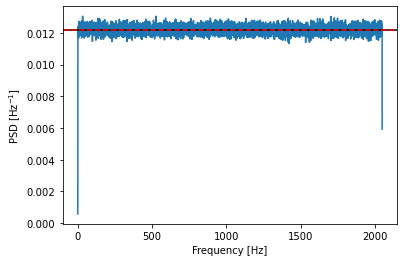

In [6]:
freqs_welch, psd_welch = welch(
    noise, fs=fs, window=('tukey', 0.25), nperseg=4*fs, 
    noverlap=2*fs)
 
plt.figure()
plt.plot(freqs_welch, psd_welch)
plt.axhline(psd, c='k')
plt.axhline(psd_2, c='r', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD $[\mathrm{Hz}^{-1}]$')
plt.show()